<a href="https://colab.research.google.com/github/DonnaVakalis/forecasting-MRT-gap/blob/main/model/model_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREAMBLE (ABOUT THIS NOTEBOOK)

This notebook applies data prediction with Keras LSTM model in Python, on time series (hourly) weather data to predict daily thermal comfort exceedances indoors (e.g., when it gets too hot, and by how much). While this notebook contains only the first steps, ultimately it can help determine how much cooling is needed (in terms of mean radiant temperature or MRT), and ultimately help decide on which cooling technologies are feasible and most carbon efficient.

# IMPORTS

In [115]:
import os
from google.colab import drive
import pickle
import glob
import numpy as np
import pandas as pd

from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, LSTM

from numpy import array

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# LOAD THE DATA

The training and testing datasets were pre-processed in a separate notebook saved as separate pickles for 2015,2016 and 2017 (and separated by training and test and output variables based on a prior project) in this public repository:

https://github.com/eta-lab/forecasting-comfort

Details about methods from this project can be found here: Rysanek, A., Nuttall, R., McCarty, J, (2021). Forecasting the impact of climate change on thermal comfort using a weighted ensemble of supervised learning models. Building & Environment.

In [2]:
# Point to the folder for this project (forecasting-MRT-gap/data)
drive.mount('/content/gdrive')
DATA_PATH = "/content/gdrive/My Drive/Colab Notebooks/forecasting-MRT-gap/data"

Mounted at /content/gdrive


## GET OUTDOOR AIR TEMPERATURES FOR SUMMER 2015, 2016 and 2017

For each year 2015,2016,2017, examine temperature data (outdoor) and prepare to remerge training/test sets (for dynamically selecting training/testing sets from whole)

(5781, 51) (4407, 51) (1374, 51)


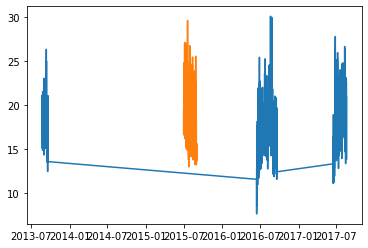

In [87]:
# 2015

dat_train = pickle.load(open(DATA_PATH +'/trainX_2015.pkl','rb'))
dat_test = pickle.load(open(DATA_PATH +'/testX_2015.pkl','rb'))

# check if train and test set are the same, and visualize temp values
df_diff = pd.concat([dat_train,dat_test]).drop_duplicates(keep=False)
print(df_diff.shape, dat_train.shape, dat_test.shape)
df_train = dat_train[['temp']]
df_test = dat_test[['temp']]
plt.plot(df_train.index, df_train.temp, df_test .index, df_test .temp)
plt.show() 

(5739, 51) (4417, 51) (1322, 51)


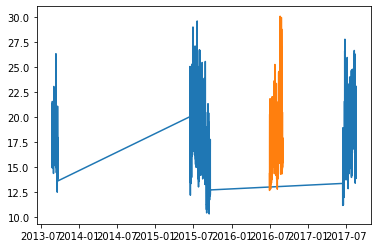

In [88]:
# 2016

dat_train = pickle.load(open(DATA_PATH +'/trainX_2016.pkl','rb'))
dat_test = pickle.load(open(DATA_PATH +'/testX_2016.pkl','rb'))

# check if 2015 train and test set are the same
df_diff = pd.concat([dat_train,dat_test]).drop_duplicates(keep=False)
print(df_diff.shape, dat_train.shape, dat_test.shape)
df_train = dat_train[['temp']]
df_test = dat_test[['temp']]
plt.plot(df_train.index, df_train.temp, df_test .index, df_test .temp)
plt.show() 

(6579, 51) (5028, 51) (1551, 51)


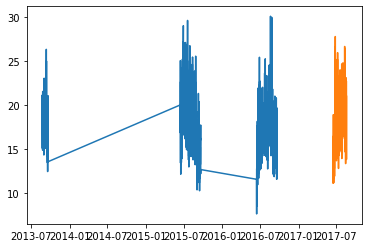

In [89]:
# 2017

dat_train = pickle.load(open(DATA_PATH +'/trainX_2017.pkl','rb'))
dat_test = pickle.load(open(DATA_PATH +'/testX_2017.pkl','rb'))

# check if train and test set are the same, and visualize temp values
df_diff = pd.concat([dat_train,dat_test]).drop_duplicates(keep=False)
print(df_diff.shape, dat_train.shape, dat_test.shape)
df_train = dat_train[['temp']]
df_test = dat_test[['temp']]
plt.plot(df_train.index, df_train.temp, df_test .index, df_test .temp)
plt.show() 

We want temperature data from all three summers, minus the smoky periods (smoke-affected days = when recorded incidences of regional forest fires)

These are respectively the first two weeks of July 2015 and the first two weeks of August 2017

In [90]:
# 2015

# get training set from another year (so complete for 2015)
df_1 = pickle.load(open(DATA_PATH +'/trainX_2016.pkl','rb'))

# keep only summer dates, e.g., June, July and August:
remove_before = pd.to_datetime('2015-06-01')
remove_after = pd.to_datetime('2015-08-31')
df_2 = df_1.query('index >= @remove_before and index <= @remove_after')

# drop smoke weeks (first two weeks July 2015) 
start_smoke = pd.to_datetime('2015-07-01')
end_smoke = pd.to_datetime('2015-07-14')
df_3 = df_2.query('index < @start_smoke or index > @end_smoke')

# save 2015 outdoor temps (x variable)
df_2015_X = df_3[['temp']]

In [91]:
# 2016 

# get training set from another year (so complete for 2016)
df_1 = pickle.load(open(DATA_PATH +'/trainX_2017.pkl','rb'))

# keep only summer dates, e.g., June, July and August:
remove_before = pd.to_datetime('2016-06-01')
remove_after = pd.to_datetime('2016-08-31')
df_2 = df_1.query('index >= @remove_before and index <= @remove_after')

# save 2016 outdoor temps (x variable)
df_2016_X = df_2[['temp']]

In [92]:
# 2017

# get training set from another year (so complete for 2017)
df_1 = pickle.load(open(DATA_PATH +'/trainX_2015.pkl','rb'))

# keep only summer dates, e.g., June, July and August:
remove_before = pd.to_datetime('2017-06-01')
remove_after = pd.to_datetime('2017-08-31')
df_2 = df_1.query('index >= @remove_before and index <= @remove_after')

# drop smoke weeks (first two weeks July 2015) 
start_smoke = pd.to_datetime('2017-08-01')
end_smoke = pd.to_datetime('2017-07-14')
df_3 = df_2.query('index < @start_smoke or index > @end_smoke')

# save 2017 outdoor temps (x variable)
df_2017_X = df_3[['temp']]

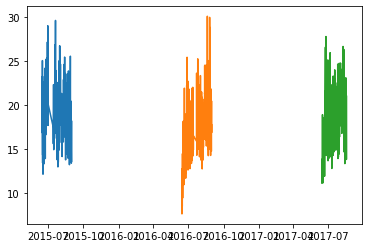

In [94]:
# plot all outdoor temperatures in cleaned dataset
plt.plot(df_2015_X.index, df_2015_X.temp, df_2016_X.index, df_2016_X.temp, df_2017_X.index, df_2017_X.temp) 
plt.show() 

# save a single dataset with all days
ls_X = [df_2015_X, df_2016_X, df_2017_X]  
df_all_X = pd.concat(ls_X)

## GET INDOOR AIR TEMPERATURES FOR SAME TIME SPANS

In [105]:
#Get raw data of indoor air temps (what we want to predict) 

df1 = pickle.load(open(DATA_PATH +'/trainY_2015.pkl','rb'))
df2 = pickle.load(open(DATA_PATH +'/trainY_2016.pkl','rb'))
df3 = pickle.load(open(DATA_PATH +'/trainY_2017.pkl','rb'))


# Put in all in one place 
ls_Y = [df1, df2, df3]  
df_Y = pd.concat(ls_Y)

# Drop duplicated date-times

df_Y = df_Y[~df_Y.index.duplicated(keep='first')]

# Drop date-times not in X set
df_all_Y = df_Y[df_Y.index.isin(df_all_X.index)]

## Plot X and Y variables

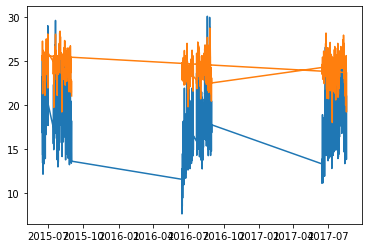

In [108]:
# plot Outdoor (X values) and Indoor (to be predicted)
plt.plot(df_all_X.index, df_all_X.temp, df_all_Y.index, df_all_Y) 
plt.show() 

# the LSTM Model

Note: The following model was created with a lot of help from the following tutorial by Otabek Yorkinov:

https://www.datatechnotes.com/2019/12/multi-output-regression-example-with_24.html


## Set up a model with one input and one output


In [116]:
x = df_all_X.copy().to_numpy()
y = df_all_Y.copy().to_numpy()

# The LSTM model input dimension requires the third dimension that will be the number of the single input row. We'll reshape the x data.
print("X before:", x.shape)

x = x.reshape(x.shape[0], x.shape[1], 1)
y = y.reshape(y.shape[0], 1)

print("X after:", x.shape, "y:", y.shape)
 

# define the input and output data dimensions from x and data.

in_dim = (x.shape[1], x.shape[2])
out_dim = y.shape[1]
 
print(in_dim)
print(out_dim)
 
# split the data into the train and test parts.

xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.15)

X before: (4632, 1)
X after: (4632, 1, 1) y: (4632, 1)
(1, 1)
1


## Define and fit the model

In [117]:
# Define
model = Sequential()
model.add(LSTM(64, input_shape=in_dim, activation="relu"))
model.add(Dense(out_dim))
model.compile(loss="mse", optimizer="adam") 
 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [119]:
# Fit using the training set

model.fit(xtrain, ytrain, epochs=100, batch_size=12, verbose=0)

## Check the predictions

Predict test data and check the mean squared error rate

In [121]:
ypred = model.predict(xtest)
 
print("Y MSE:%.4f" % mean_squared_error(ytest[:,0], ypred[:,0]))


Y MSE:2.2183


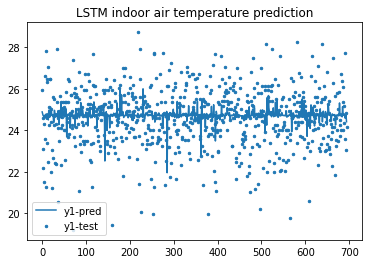

In [122]:
# Visualize Results

x_ax = range(len(xtest))
plt.title("LSTM indoor air temperature prediction")
plt.scatter(x_ax, ytest[:,0],  s=6, label="y1-test")
plt.plot(x_ax, ypred[:,0], label="y1-pred")
plt.legend()
plt.show()